# Response Synthesis and Query Engines in LlamaIndex
* Notebook by Adam Lang
* Date: 3/21/2024
* In the first part of this notebook we will review the Response Synthesis and then the Query Engine portions of LlamaIndex.


# What is Response Synthesis?
* Generates the response from the user query and top k retrieved semantic chunks of text.
* Different types of Response Synthesizers in LlamaIndex
  1. Refine
  2. Compact
  3. Tree Summarize
  4. Accumulate
  5. Compact Accumulate
* As a reminder this is the portion of the RAG pipeline we are referring to:

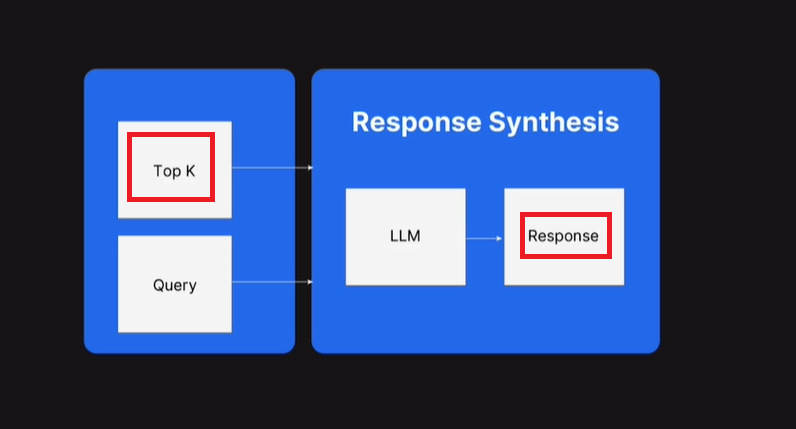



# Architecture of the Response Synthesizers

## Refine
* Takes first chunk from first query => refines => returns 2nd refined chunk

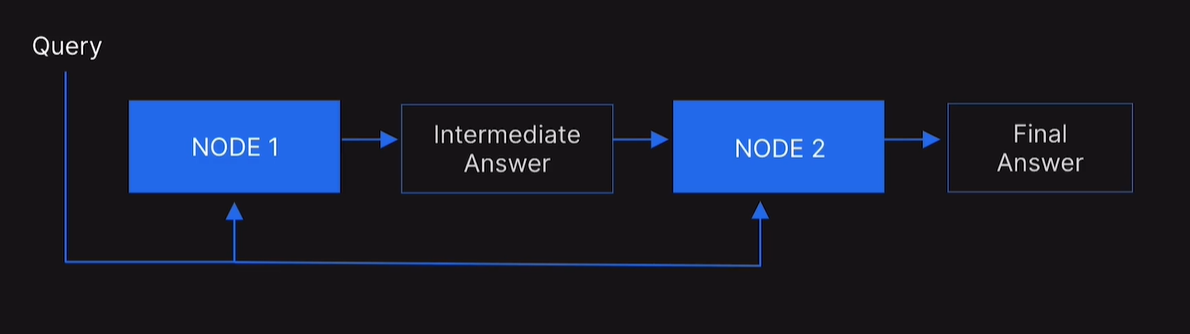

## Compact
* Concatenates as many chunks as can fit in a context window resulting in less calls to the LLM.
* Some overlap occurs during concatenation.
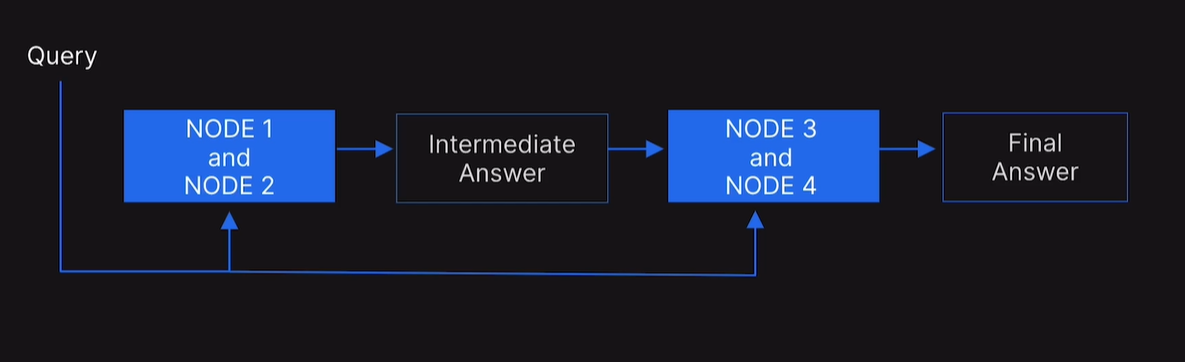

## Accumulate
* Given a set of text chunks + query
* applies query to each text chunk
* accumulates response into an array
* returns concatenated string of responses

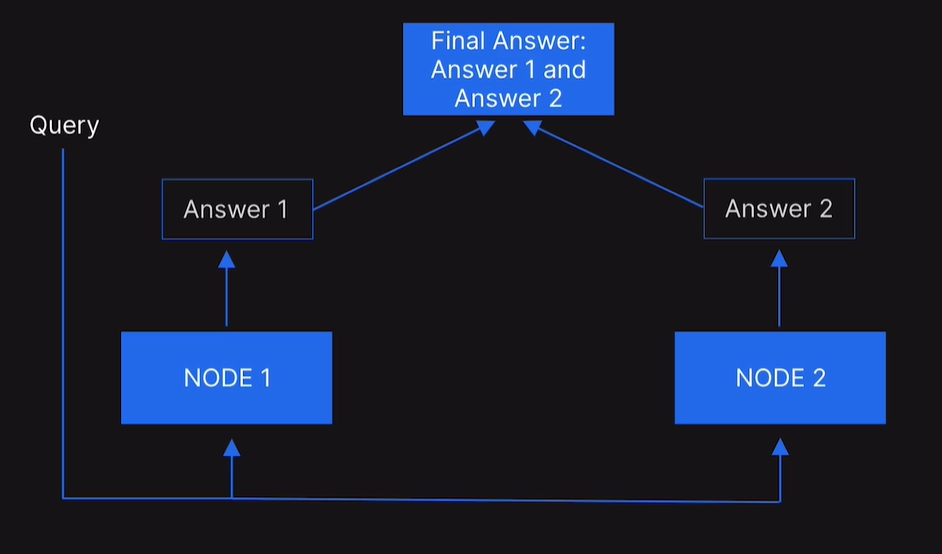

## Compact Accumulate
* Same as accumulate but compacts the output
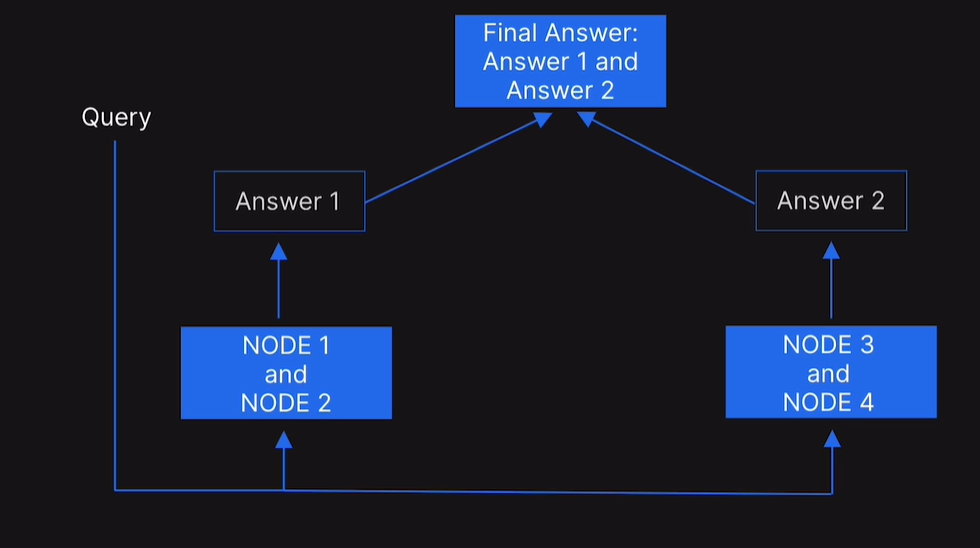

## Tree Summarize
* Generates response by querying LLM in various chunks or tree traversals.
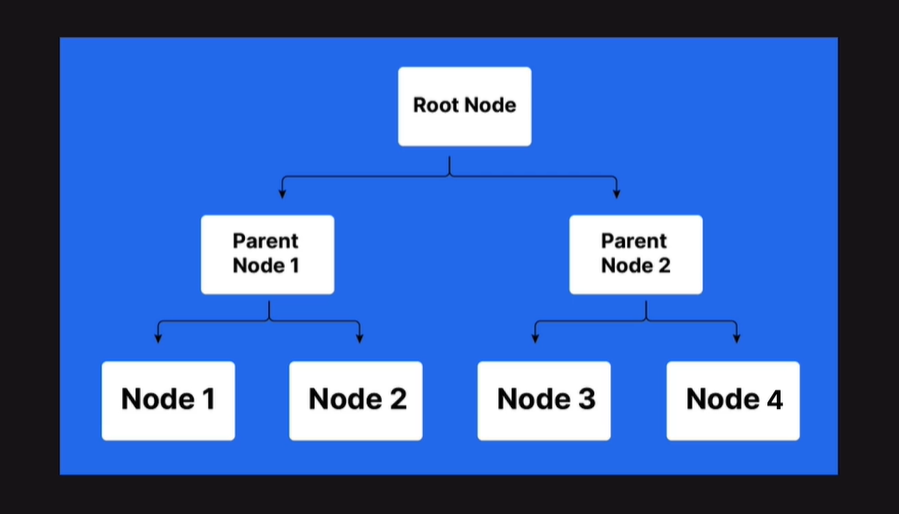

# Query Engines
* Combines a `Retriever` + `Response Synthesizer` => `Query Engine`

## Challenges with Query Engines
1. Good for QA systems
2. Cannot answer follow up questions

## Chat Engines
* Enables conversation with your data
* Concept: keep track of chat history and perform RAG to have a conversation with this.

# Query Engine Implementation in LlamaIndex

In [12]:
!pip install llama_index

In [6]:
# set up openai
import os
os.environ["OPENAI_API_KEY"] = '<your_key>'

### Download Dataset

In [4]:
!mkdir data
!wget 'https://raw.githubusercontent.com/aravindpai/Speech-Recognition/1882379d3152c8cd830d74e677be4dd161d024ea/transformers.pdf' -O 'data/transformers.pdf'

--2024-03-21 20:48:11--  https://raw.githubusercontent.com/aravindpai/Speech-Recognition/1882379d3152c8cd830d74e677be4dd161d024ea/transformers.pdf
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2215244 (2.1M) [application/octet-stream]
Saving to: ‘data/transformers.pdf’

data/transformers.p 100%[===================>]   2.11M  --.-KB/s    in 0.06s   

2024-03-21 20:48:12 (34.8 MB/s) - ‘data/transformers.pdf’ saved [2215244/2215244]



In [7]:
# create pdf reader
from pathlib import Path
from llama_index.core import download_loader

# create pdf reader
PDFReader = download_loader("PDFReader")

# create loader and documents
loader = PDFReader()
documents = loader.load_data(file=Path('./data/transformers.pdf'))

<ipython-input-7-e649ebeddd6c>:6: DeprecationWarning: Call to deprecated function (or staticmethod) download_loader. (`download_loader()` is deprecated. Please install tool using pip install directly instead.)
  PDFReader = download_loader("PDFReader")


In [16]:
# build index
from llama_index.core import VectorStoreIndex

# index creation
index = VectorStoreIndex.from_documents(documents)

In [19]:
# configure a retriever
from llama_index.core.retrievers import VectorIndexRetriever

# retriever
retriever = VectorIndexRetriever(
    index=index,
    similarity_top_k=10
)

In [21]:
# configure a response synthesizer
from llama_index.core import get_response_synthesizer

# create response synth
response_synthesizer = get_response_synthesizer(
    response_mode="compact"
)

# Query Engine Creation

In [24]:
# create query engine
query_engine = index.as_query_engine()


In [25]:
# response
response = query_engine.query(
    "Give me the author of transformers"
)

In [26]:
print(response)

The authors of the Transformers model are Ashish Vaswani, Noam Shazeer, Niki Parmar, Jakob Uszkoreit, Llion Jones, Aidan N. Gomez, Łukasz Kaiser, and Illia Polosukhin.


In [29]:
## can view response source nodes
response.source_nodes[0].text

'[5]Kyunghyun Cho, Bart van Merrienboer, Caglar Gulcehre, Fethi Bougares, Holger Schwenk,\nand Yoshua Bengio. Learning phrase representations using rnn encoder-decoder for statistical\nmachine translation. CoRR , abs/1406.1078, 2014.\n[6]Francois Chollet. Xception: Deep learning with depthwise separable convolutions. arXiv\npreprint arXiv:1610.02357 , 2016.\n[7]Junyoung Chung, Çaglar Gülçehre, Kyunghyun Cho, and Yoshua Bengio. Empirical evaluation\nof gated recurrent neural networks on sequence modeling. CoRR , abs/1412.3555, 2014.\n[8]Chris Dyer, Adhiguna Kuncoro, Miguel Ballesteros, and Noah A. Smith. Recurrent neural\nnetwork grammars. In Proc. of NAACL , 2016.\n[9]Jonas Gehring, Michael Auli, David Grangier, Denis Yarats, and Yann N. Dauphin. Convolu-\ntional sequence to sequence learning. arXiv preprint arXiv:1705.03122v2 , 2017.\n[10] Alex Graves. Generating sequences with recurrent neural networks. arXiv preprint\narXiv:1308.0850 , 2013.\n[11] Kaiming He, Xiangyu Zhang, Shaoqing

In [27]:
# another response
response = query_engine.query(
    "What is the use of positional encoding in NLP?"
)

In [28]:
print(response)

Positonal encoding in NLP is used to provide information about the position of words in a sequence.


In [32]:
## view response source nodes
response.source_nodes[1].text

'Table 3: Variations on the Transformer architecture. Unlisted values are identical to those of the base\nmodel. All metrics are on the English-to-German translation development set, newstest2013. Listed\nperplexities are per-wordpiece, according to our byte-pair encoding, and should not be compared to\nper-word perplexities.\nN d model dff h d k dvPdrop ϵlstrain PPL BLEU params\nsteps (dev) (dev) ×106\nbase 6 512 2048 8 64 64 0.1 0.1 100K 4.92 25.8 65\n(A)1 512 512 5.29 24.9\n4 128 128 5.00 25.5\n16 32 32 4.91 25.8\n32 16 16 5.01 25.4\n(B)16 5.16 25.1 58\n32 5.01 25.4 60\n(C)2 6.11 23.7 36\n4 5.19 25.3 50\n8 4.88 25.5 80\n256 32 32 5.75 24.5 28\n1024 128 128 4.66 26.0 168\n1024 5.12 25.4 53\n4096 4.75 26.2 90\n(D)0.0 5.77 24.6\n0.2 4.95 25.5\n0.0 4.67 25.3\n0.2 5.47 25.7\n(E) positional embedding instead of sinusoids 4.92 25.7\nbig 6 1024 4096 16 0.3 300K 4.33 26.4 213\ndevelopment set, newstest2013. We used beam search as described in the previous section, but no\ncheckpoint averagin

In [35]:
## ask follow up question
response = query_engine.query(
    "summarize the use of positional encoding in NLP in 250 characters"
)

In [36]:
print(response)

Positional encoding in NLP is crucial for transformers to understand the sequential order of words in a sentence. It assigns unique values to each position, enabling the model to differentiate between words based on their position in the input sequence, enhancing the model's ability to capture dependencies and relationships within the text.


# Chat Engine

In [39]:
chat_engine = index.as_chat_engine()

In [38]:
response = chat_engine.chat(
    "What is the use of positional encodings in NLP"
)

In [40]:
print(response)

Positional encodings in NLP are used to provide information about the relative or absolute position of tokens in a sequence. They are added to input embeddings to help the model understand the order of tokens in a sequence.


### Now ask follow up question!

In [41]:
response = chat_engine.chat(
    "Summarize it in 250 characters"
)

In [42]:
print(response)

The text discusses training a model for machine translation using self-attention and convolutional layers, detailing data, hardware, optimizer, and regularization techniques employed.


Now we can see that the LLM was able to answer the follow up questions using the `chat_engine`